# Introducing the LSTM and GRU Models

The purpose of this notebook is to create and analyze LSTM and GRU models, examining their architectures and understanding the key differences between them. By the end of this notebook, you will have a clear understanding of how to implement these models and the scenarios in which each one excels.

Long Short-Term Memory (LSTM)

LSTM models were introduced by Hochreiter and Schmidhuber in 1997 as a solution to the vanishing gradient problem inherent in traditional RNNs. LSTMs are capable of learning long-term dependencies in data, which makes them particularly powerful for tasks where the context from previous time steps is crucial. This is achieved through a sophisticated gating mechanism, which regulates the flow of information through the cell state.

Gated Recurrent Unit (GRU)

GRU models, introduced by Cho et al. in 2014, are a simpler alternative to LSTMs. They combine the forget and input gates into a single update gate and merge the cell state and hidden state, reducing the complexity of the model. GRUs often perform similarly to LSTMs but are computationally more efficient, making them easier to train and modify.

Key Differences
- Complexity: LSTMs have three gates (input, forget, and output) and a cell state, whereas GRUs have two gates (reset and update) and do not maintain a separate cell state.
- Training Efficiency: GRUs are generally faster to train due to their simpler architecture.
- Performance: Both models can achieve comparable performance, but the choice between them can depend on the specific task and dataset.

# References
Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. Neural computation, 9(8), 1735-1780.

Cho, K., Van Merriënboer, B., Bahdanau, D., & Bengio, Y. (2014). On the properties of neural machine translation: Encoder-decoder approaches. arXiv preprint arXiv:1409.1259.

In [1]:
from typing import Tuple
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Recurrent Neural Networks (RNNs) Overview:

There are different types of RNNs:

- One to One RNN
- One to Many RNN
- Many to One RNN
- Many to Many RNN

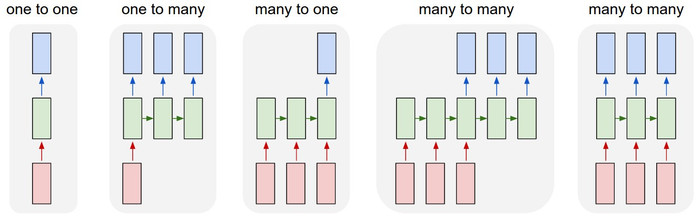

## One-to-One RNN
A One-to-One RNN (Tx=Ty=1) is the most basic form of neural network where a single input maps to a single output. This type of architecture is often referred to as a Vanilla Neural Network. It is used in traditional machine learning problems where the task is to make a single prediction from a single input feature vector.

Example: Image classification is a common application where the network takes an image (single input) and outputs a label identifying the object in the image (single output).

## One-to-Many RNN
A One-to-Many RNN (Tx=1, Ty>1) generates a sequence of outputs from a single input. This is useful in scenarios where a single event or item needs to produce a series of results.

Example:

Music Generation: Starting from a single note (input), the model generates a sequence of notes to create a musical piece (multiple outputs).
Text Generation: Given a single word or phrase, the model generates a complete sentence or paragraph.

## Many-to-One RNN
A Many-to-One RNN (Tx>1, Ty=1) processes a sequence of inputs to produce a single output. This is typically used in tasks where the final result depends on the entire sequence of inputs.

Example:

Sentiment Analysis: The model takes a sequence of words (input text) and outputs a sentiment label (positive, negative, or neutral).
Movie Rating Prediction: Based on a review text (multiple words), the model predicts a single rating score for the movie.

## Many-to-Many RNN
Many-to-Many RNNs handle sequences as both inputs and outputs, and they come in two variations:

Equal Length (Tx=Ty):

In this case, the length of the input sequence is equal to the length of the output sequence, meaning each input has a corresponding output.

Example:

Named Entity Recognition (NER): The model processes each word in a sentence (input) and outputs a label for each word indicating whether it is a named entity (person, location, organization, etc.).
Unequal Length (Tx≠Ty):

Here, the input and output sequences can have different lengths, which is useful for tasks where the output sequence length varies from the input.

Example:

Machine Translation: Translating sentences from one language to another often results in sequences of different lengths. For instance, translating the English phrase "I love you" (3 words) to Spanish "Te amo" (2 words).

# Recurrent Neural Networks (RNNs)

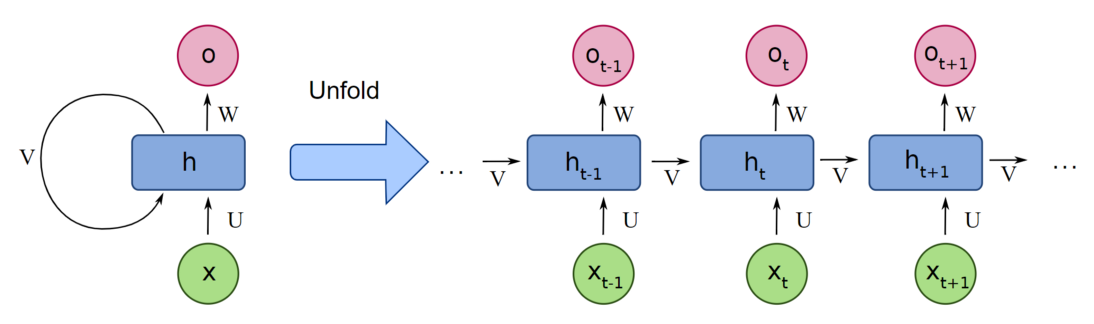

In [2]:
class RecurrentNeuralNetwork(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int = 128):
        super(RecurrentNeuralNetwork, self).__init__()
        self.hidden_state_dim = hidden_dim
        self.fc1 = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim) 
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, _ = x.size()
        h = self.init_hidden(batch_size, x.device)
        predictions = []
        for t in range(seq_len):
            combined = torch.cat((x[:, t, :], h), dim=1)
            h = torch.tanh(self.fc1(combined))
            output = self.fc2(h)
            predictions.append(output)
        predictions = torch.cat(predictions, dim=1)  # Concatenate along seq_len dimension
        return predictions
    
    def init_hidden(self, batch_size, device):
        return torch.zeros(batch_size, self.hidden_state_dim, device=device)

In [3]:
model = RecurrentNeuralNetwork(input_dim=1, output_dim=1)
x = torch.tensor([
    [[0.0], [1.0], [2.0], [3.0]],
    [[3.0], [2.0], [1.0], [0.0]],
])
output = model(x)
print(output.detach())

tensor([[-0.0524, -0.0497, -0.0411, -0.0245],
        [-0.0019, -0.0509, -0.0625, -0.0754]])


# Long-Short Term Memory (LSTM) Model

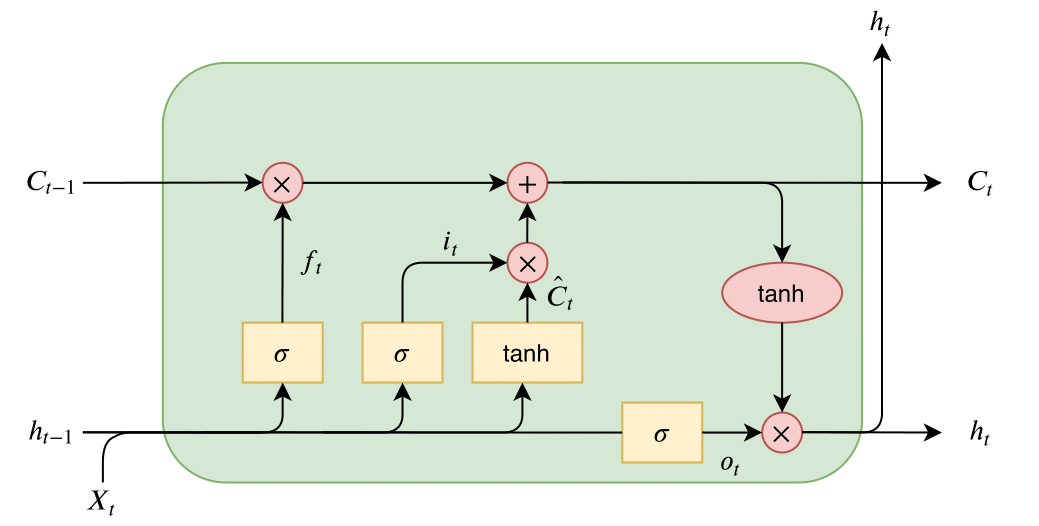

In [4]:
class LSTMCell(nn.Module):
    def __init__(self, n_features:int, hidden_size:int, output_seq_length:int):
        super().__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.output_seq_length = output_seq_length
        self.forget_gate = nn.Linear(n_features + hidden_size, hidden_size) # f_t = sigmoid(W_f * [h_t-1, x_t])
        self.input_gate = nn.Linear(n_features + hidden_size, hidden_size) # i_t = sigmoid(W_i * [h_t-1, x_t])
        self.cell_gate = nn.Linear(n_features + hidden_size, hidden_size) # g_t = tanh(W_g * [h_t-1, x_t])
        self.output_gate = nn.Linear(n_features + hidden_size, hidden_size) # o_t = sigmoid(W_o * [h_t-1, x_t])
        self.output_layer = nn.Linear(hidden_size, output_seq_length) # y_t = W_y * h_t

    def forward(
        self, 
        x:torch.tensor, 
        internal_state:Tuple[torch.tensor, torch.tensor],
            ) -> Tuple[torch.tensor, Tuple[torch.tensor, torch.tensor]]:
        hidden_state_prev, cell_state_prev = internal_state
        combined = torch.cat((x, hidden_state_prev), dim=1)
        forget_gate = F.sigmoid(self.forget_gate(combined))
        input_gate = F.sigmoid(self.input_gate(combined))
        output_gate = F.sigmoid(self.output_gate(combined))
        cell_gate = F.tanh(self.cell_gate(combined))

        cell_state = forget_gate * cell_state_prev + input_gate * cell_gate
        hidden_state = output_gate * F.tanh(cell_state)
        output = self.output_layer(hidden_state)
        internal_state = (hidden_state, cell_state)

        return output, internal_state
        

In [5]:
class LSTM(nn.Module):
    def __init__(self, n_features:int, output_len:int, hidden_size:int, n_cells:int):
        super().__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.n_cells = n_cells
        self.lstm_cells = nn.ModuleList([
            LSTMCell(
                n_features=self.n_features if layer == 0 else hidden_size,
                hidden_size=hidden_size,
                output_seq_length=hidden_size,
            ) for layer in range(self.n_cells)
        ])
        self.output_layer = nn.Linear(hidden_size, output_len)

    def forward(self, x, internal_state=None):
        batch_size, n_steps, _ = x.size()

        # Initialize hidden state for all layers if not provided
        if internal_state is None:
            internal_state = [
                (torch.zeros(batch_size, self.hidden_size), torch.zeros(batch_size, self.hidden_size))
                for _ in range(self.n_cells)
            ]

        # Forward pass through LSTM layers
        outputs = []
        for step in range(n_steps):
            # Parse current step from input tensor
            # day 1: input_tensor[:, 0, :]
            # day 2: input_tensor[:, 1, :]
            # Shape: (batch_size, step, n_features) -> (batch_size, n_features)
            current_input = x[:, step, :]
            
            # Forward through each layer
            for layer_idx, cell in enumerate(self.lstm_cells):
                # Forward through cell
                # Shape: (batch_size, n_features), (batch_size, hidden_size) -> (batch_size, n_features), (batch_size, hidden_size)
                current_input, internal_state[layer_idx] = cell(current_input, internal_state[layer_idx])

            # Append output
            outputs.append(current_input)

        # Stack and reshape outputs
        # Shape: (batch_size, n_steps, n_features) -> (batch_size, n_features, n_steps)
        stacked_outputs = torch.stack(outputs, dim=1)
        # Shape: (batch_size, n_features, n_steps) -> (batch_size, n_steps, n_features)
        reshaped_outputs = stacked_outputs.view(batch_size, n_steps, -1)

        # extract prediction embedding from last step
        # Shape: (batch_size, n_steps, n_features) -> (batch_size, n_features)
        final_output = reshaped_outputs[:, -1, :]

        # Forward through output layer
        # Shape: (batch_size, n_features) -> (batch_size, output_size)
        final_output = self.output_layer(final_output)

        return final_output, internal_state

In [6]:
input_seq_length = 10
n_features = 1
batch_size = 3
output_seq_length = 5
hidden_size = 20
n_cells = 2

# Create a random input tensor
# Shape: (batch_size, seq_length, n_features)
input_tensor = torch.rand((batch_size, input_seq_length, n_features))
print(f"The input tensor shape is: {input_tensor.shape}")

# Create an LSTM model
lstm = LSTM(n_features, output_seq_length, hidden_size, n_cells)

# Forward pass
output, all_hidden_states = lstm(input_tensor)
print(f"The output tensor shape is: {output.shape}")

The input tensor shape is: torch.Size([3, 10, 1])
The output tensor shape is: torch.Size([3, 5])


# Gated Recurrent Unit (GRU) Model

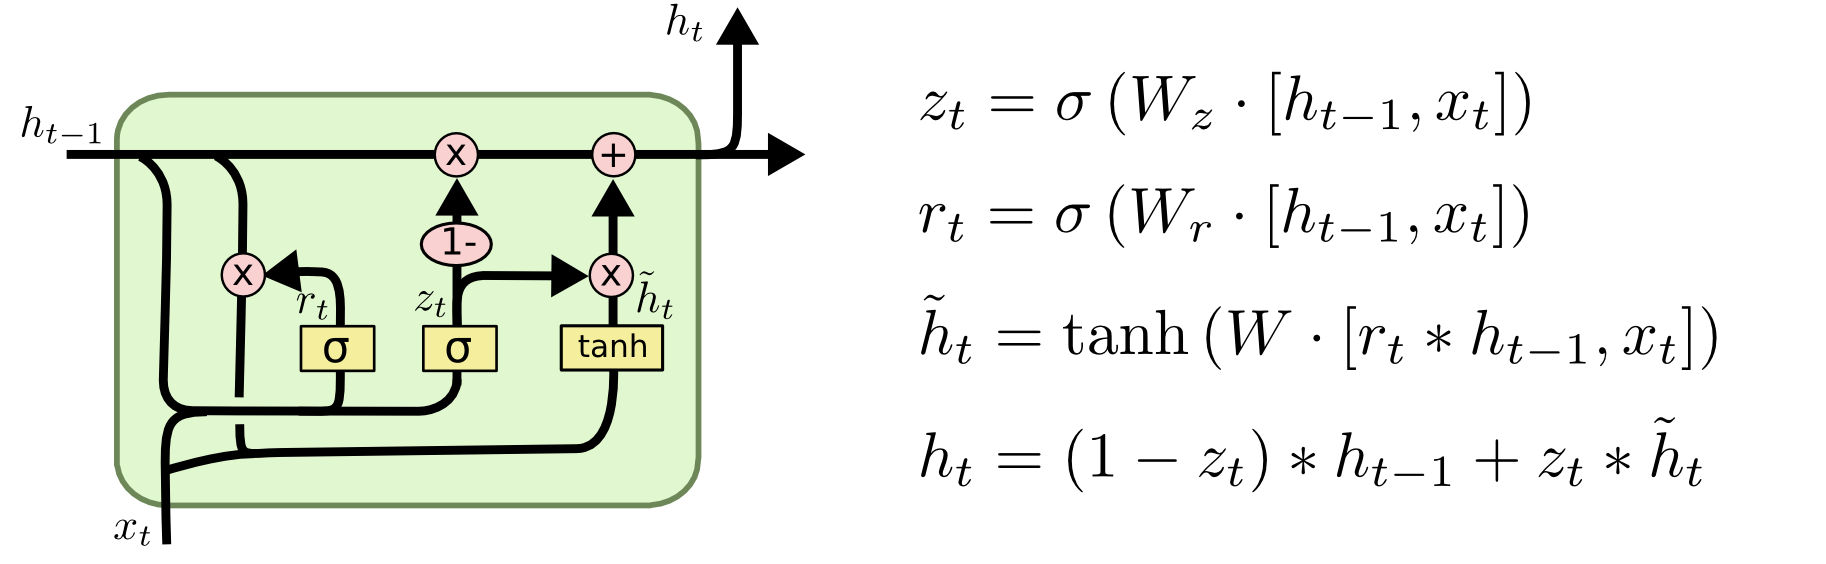

In [7]:
class GRUCell(nn.Module):
    def __init__(self, n_features, hidden_size):
        super().__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.reset_gate = nn.Linear(n_features + hidden_size, hidden_size) # r_t
        self.update_gate = nn.Linear(n_features + hidden_size, hidden_size) # z_t
        self.memory_content = nn.Linear(n_features + hidden_size, hidden_size) # h_t
        self.output_layer = nn.Linear(hidden_size, hidden_size) # y_t

    def forward(self, x, hidden):
        reset_gate = F.sigmoid(self.reset_gate(torch.cat((x, hidden), dim=1)))
        update_gate = F.sigmoid(self.update_gate(torch.cat((x, hidden), dim=1)))
        memory_content = F.tanh(self.memory_content(torch.cat((torch.mul(reset_gate, hidden), x), dim=1)))
        updated_hidden = torch.mul((1 - update_gate), hidden) + torch.mul(update_gate, memory_content)
        output = self.output_layer(updated_hidden)

        return output, updated_hidden

In [8]:
class GRU(nn.Module):
    def __init__(self, n_features:int, output_len:int, hidden_size:int, n_cells:int):
        super().__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.n_cells = n_cells
        self.gru_cells = nn.ModuleList([
            GRUCell(
                n_features=self.n_features if layer == 0 else hidden_size,
                hidden_size=hidden_size,
            ) for layer in range(self.n_cells)
        ])
        self.output_layer = nn.Linear(hidden_size, output_len)

    def forward(self, x, internal_state=None):
        batch_size, n_steps, _ = x.size()

        # Initialize hidden state for all layers if not provided
        if internal_state is None:
            internal_state = [torch.zeros(batch_size, self.hidden_size) for _ in range(self.n_cells)]

        outputs = []
        for step in range(n_steps):
            current_input = input_tensor[:, step, :]

            # Forward through each layer
            for layer_idx in range(self.n_cells):
                current_input, internal_state[layer_idx] = self.gru_cells[layer_idx](current_input, internal_state[layer_idx])

            outputs.append(current_input)

        # Stack and reshape outputs
        stacked_outputs = torch.stack(outputs, dim=1)
        reshaped_outputs = stacked_outputs.view(batch_size, n_steps, -1)

        # Take the last step's output as the final output
        final_output = reshaped_outputs[:, -1, :]

        # Final output layer
        final_output = self.output_layer(final_output)

        return final_output, internal_state

In [9]:
input_seq_length = 10
n_features = 1
batch_size = 3
output_seq_length = 5
hidden_size = 20
n_cells = 2

# Create a random input tensor
# Shape: (batch_size, seq_length, n_features)
input_tensor = torch.rand((batch_size, input_seq_length, n_features))
print(f"The input tensor shape is: {input_tensor.shape}")

# Create a GRU model
gru = GRU(n_features, output_seq_length, hidden_size, n_cells)

# Forward pass
output, all_hidden_states = gru(input_tensor)
print(f"The output tensor shape is: {output.shape}")

The input tensor shape is: torch.Size([3, 10, 1])
The output tensor shape is: torch.Size([3, 5])
